In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils


In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch

#### Load datasets

In [3]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1)]))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

(<PIL.Image.Image image mode=L size=16x16 at 0x7EFCBF151A58>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7EFCBF14E160>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7EFCBF09F278>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7EFCBF0CAA20>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7EFCBF085550>, 0)


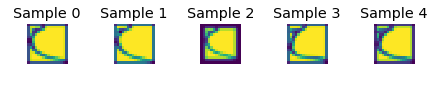

In [4]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]))
    # print(np.asarray(sample[0]))
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Define generator & GAN

In [20]:
from models.generator import _G
from models.discriminator import _D
from models.gan import GAN
import PIL.ImageOps

In [22]:
import time
import pickle

transforms = [#tfs.RandomAffine(0, scale=(0.3, 1.)),
              tfs.Resize((112, 112)),
              tfs.Grayscale(1),
              tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
              tfs.ToTensor()]

gan = GAN(epochs=100, input_h_w=112, data_path='data/png_clasificados/',
          transforms=transforms)
gan.train()
print("Training finished!")


---------- Networks architecture -------------
_G(
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=100352, bias=True)
    (4): BatchNorm1d(100352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Total number of parameters: 103262401
_D(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3

/home/celia/code/vasijas/models/gan.py:164: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  self.train_hist['D_loss'].append(D_loss.data[0])
/home/celia/code/vasijas/models/gan.py:175: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  self.train_hist['G_loss'].append(G_loss.data[0])


Avg one epoch time: 3.13, total 100 epochs time: 315.32
Training finish!... save training results
Training finished!


In [23]:
sample_z_ = Variable(torch.rand((64, 64)).cuda())
samples = gan.G(sample_z_)
samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)

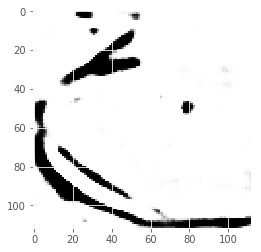

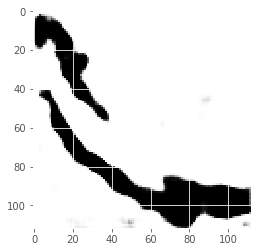

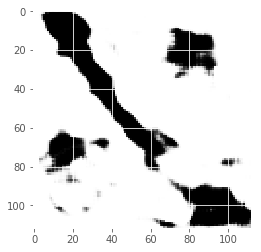

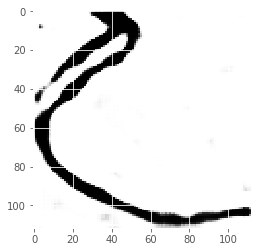

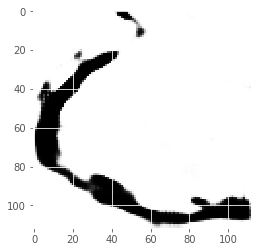

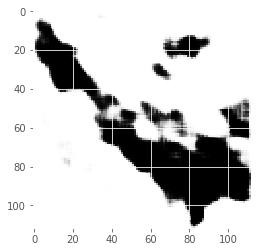

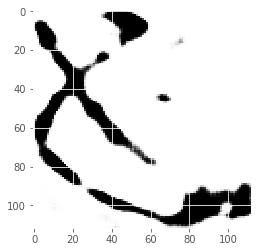

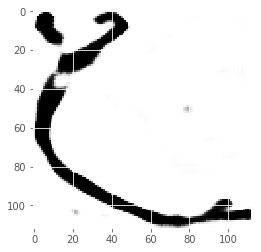

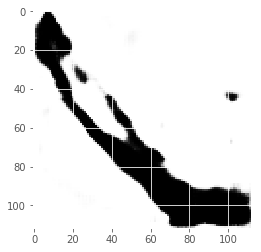

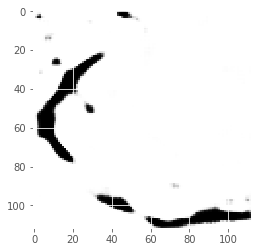

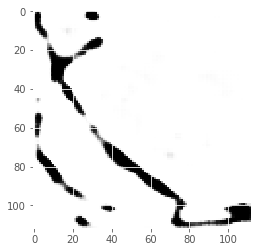

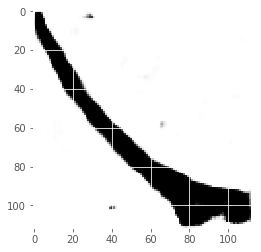

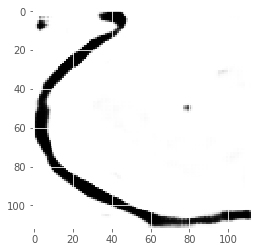

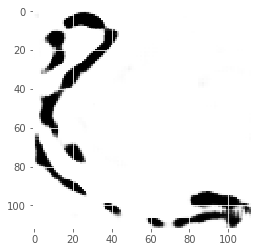

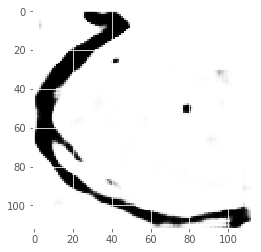

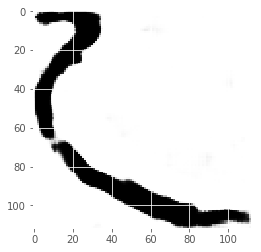

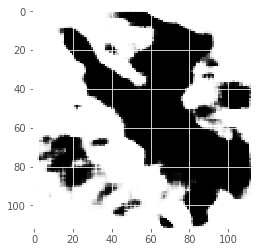

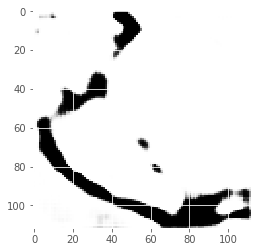

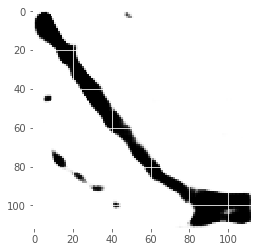

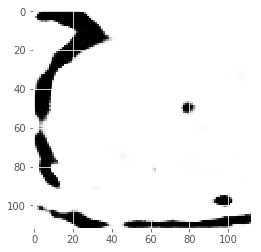

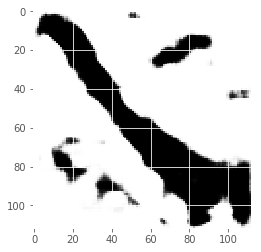

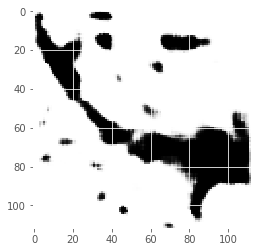

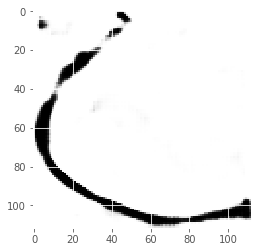

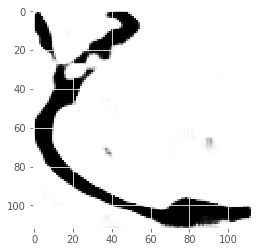

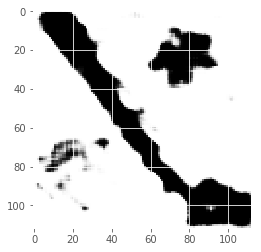

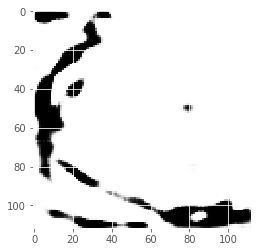

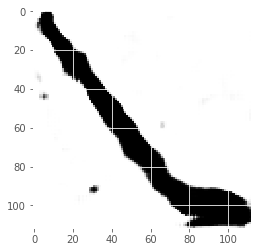

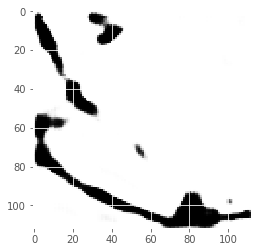

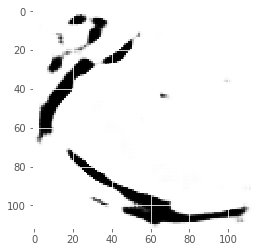

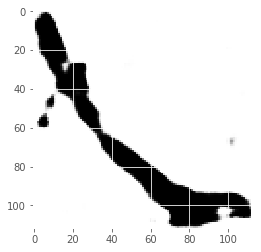

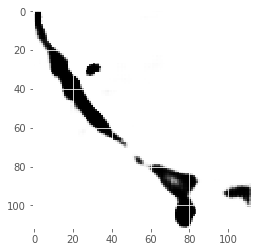

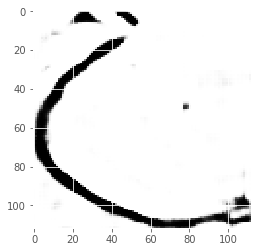

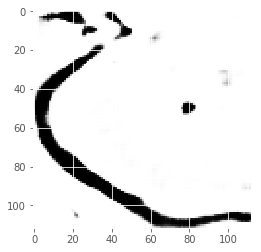

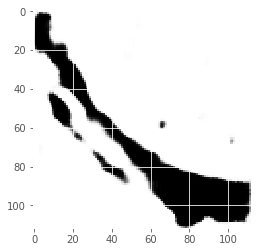

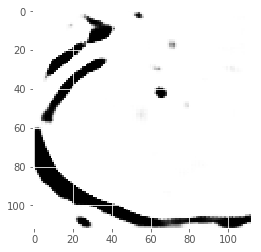

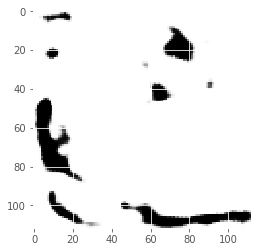

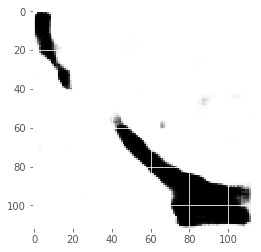

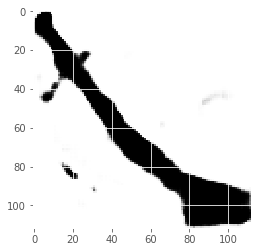

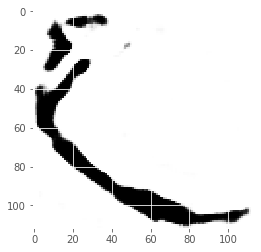

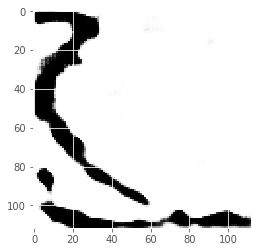

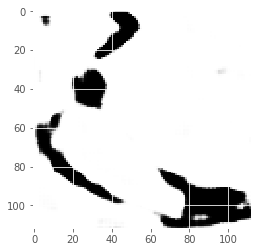

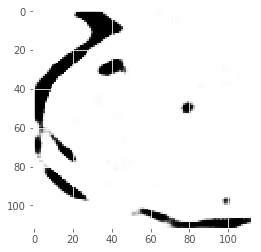

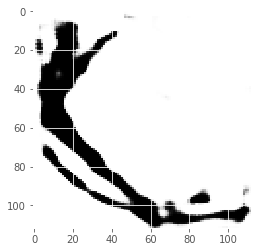

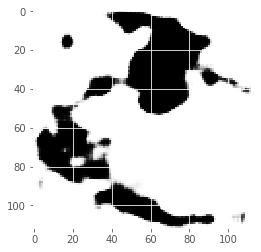

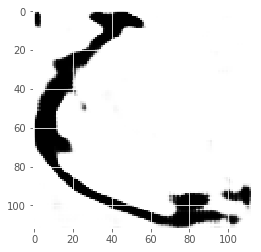

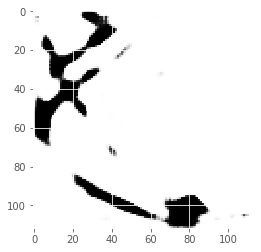

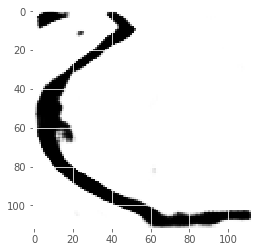

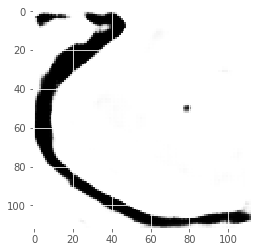

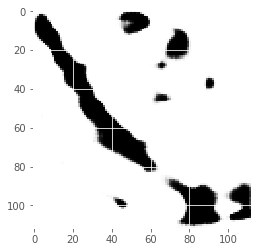

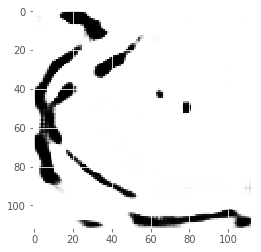

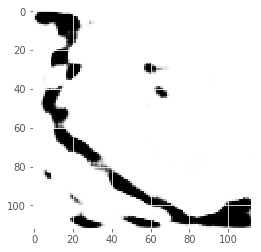

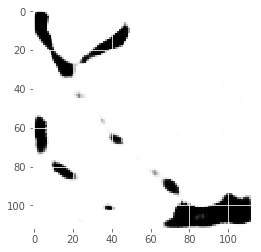

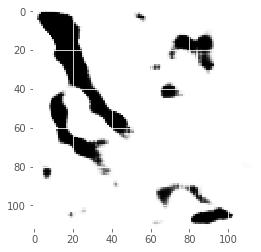

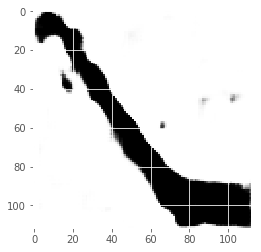

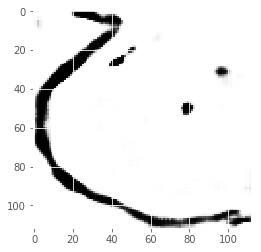

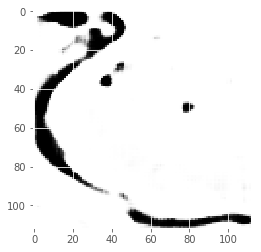

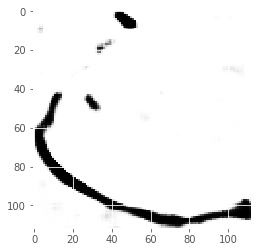

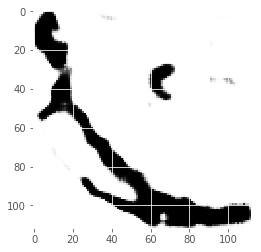

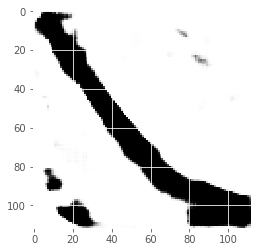

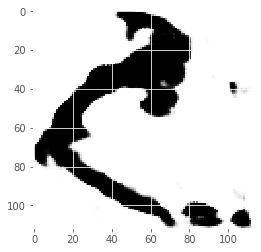

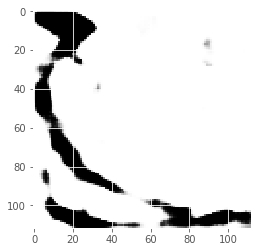

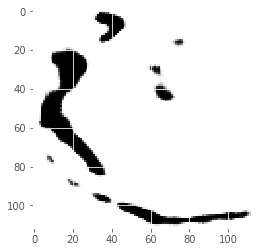

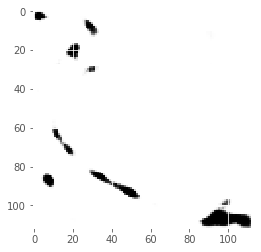

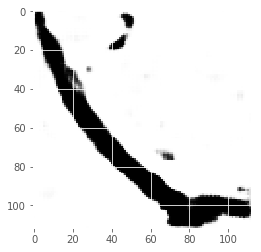

In [30]:
images = np.squeeze(samples)

for i, image in enumerate(images):
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.imsave('/tmp/image_'+ str(i) + '.png', image, cmap=plt.cm.gray_r)
    plt.show()


In [ ]:
from IPython.display import Image

with open('/tmp/GAN_epochs.gif','rb') as f:
    display(Image(data=f.read(), format='png'))